## <h1 align="center">Actividad: Evaluando Modelo de Tópicos y el algoritmo Latent Dirichlet Allocation (LDA)</h3>

<div style="border: 2px solid #1c75c8; background-color: #c5ddf6;">
<h2> Preámbulo</h2>
<p> En esta actividad se utilizan los recursos siguientes:<p>
<ul>
    <li>Biblioteca <a href="http://scikit-learn.org/stable/install.html/">SciKit-learn</a> de Python</li>
    <li>Código disponible en  <a href="https://github.com/lda-project/lda/">lda-project</a></li>
    <li>Biblioteca <a href="https://pypi.org/project/tmtoolkit/"> tmtoolkit</a>
    </li>
</ul>
<p> La actividad requiere el uso de Python 3.x y <a href="http://jupyter.org/install">Jupyter Notebook</a>. El código entregado fue probado con Python 3.7.3. Para saber cuál versión de Python usted está utilizando, ejecutar la celda siguiente (está información es importante cuando se necesitará instalar nuevos paquetes.)
</p>
</div>

In [1]:
import sys
print(sys.version)

3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]



<div style="border: 2px solid #D24747; background-color:#F8B4B4">
<h2>Objetivos de la actividad</h2>
<p>El <b>objetivo general</b> de esta actividad  es utilizar distintas medidas de calidad de la estructura de tópicos que el modelo LDA permite extraer de datos textuales.</p>
<p> Utilizaremos la perplejidad en una primera fase para medir la calidad de la estructura de tópicos, tal como se sugiere en <a href= "https://drive.google.com/open?id=1BobImO3192hifZPLXowd14gryVAUzBPW"> Blei, 2003</a></p>  
<p> En una segunda fase, y siguiendo a <a href= "http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf"> Roder et al, 2016 </a> utilizaremos medidas de coherencia con el mismo objetivo.</p>
<p> Ambos procesos se llevarán a cabo con los dos métodos de estimación </p>
</div>
    
  

<div style="border: 2px solid #D24747; background-color:#F8B4B4">
<p>Utilizaremos las 100 primeras noticias de un conjunto de datos provenientes del periódico El Dinamo.</p>   
<p>El primer paso es la lectura de datos: </p></div>

In [2]:
import pandas as pd
#from pandasql import sqldf #para utilizar una síntaxis SQL para consultar nuestros datos

dataset="dataset_eldinamo_13122019.csv"
df = pd.read_csv(dataset)
df[:5]

,url,date,text
0,https://www.eldinamo.cl/nacional/2019/12/13/mo...,13 de Diciembre de 2019,El ministro de Vivienda Cristián Monckeberg ...
1,https://www.eldinamo.cl/nacional/2019/12/13/go...,13 de Diciembre de 2019,La Moneda informó que Sebastián Piñera decretó...
2,https://www.eldinamo.cl/nacional/2019/12/13/co...,13 de Diciembre de 2019,La Corte de apelaciones de Santiago declaró ad...
3,https://www.eldinamo.cl/nacional/2019/12/13/in...,13 de Diciembre de 2019,Luego que durante esta mañana la Organización ...
4,https://www.eldinamo.cl/nacional/2019/12/13/in...,13 de Diciembre de 2019,Tras varias semanas de espera la misión de ob...


In [3]:
noticias = df[:100].text
len(noticias)
noticias[:10]

0    El ministro de Vivienda  Cristián Monckeberg  ...
1    La Moneda informó que Sebastián Piñera decretó...
2    La Corte de apelaciones de Santiago declaró ad...
3    Luego que durante esta mañana la Organización ...
4    Tras varias semanas de espera  la misión de ob...
5    A través de un documento de cinco páginas  el ...
6    El Presidente Sebastián Piñera expresó este ju...
7    A eso de las 18:13 horas del pasado lunes se e...
8    Con opiniones en contra y otras a favor comenz...
9    Con votos de diputados del Partido Radical  de...
Name: text, dtype: object

In [4]:
import spacy
nlp = spacy.load("es_core_news_sm")

def spacy_tokenizer(texto):
    # crea lista de tokens a partir de un texto
    mytokens = []
    doc = nlp(texto.lower().strip())
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and not token.is_digit and not token.like_num:
            mytokens.append(token.lemma_)
    return mytokens




<div style="border: 2px solid #1c75c8; background-color: #F8B4B4">
<p>En lo que sigue se construye un modelo probabilista de tópicos, considerando de 1 a 9 tópicos (para comparar con Kmeans
 y el algoritmo LDA estimado con el <a href="https://drive.google.com/open?id=1AoCcmg91Y1yRwM_Ox4Nvf6PGSQ9TybpE">, método de Bayes Variacional</a>, disponible como desarrollo en <a href="http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html">sklearn-lda.</a></p> 
Previo a ello se utiliza la clase CountVectorizer y su función fit_transform que permite construir una matriz tf (DTM, Document-Term Matrix) que contiene la frecuencia de aparición de cada término del vocabulario en cada texto analizado. En la definición de la clase se especifica que:
<ol>
    <li>los términos que  aparecen sólo una vez en algún texto no serán considerados en el vocabulario (min_df=2)</li>
    <li> los términos que  aparecen en mas del 95% de los textos no serán considerados en el vocabulario (max_df=0.95)</li>
    <li> se considera adicionalmente un conjunto de stop words construido ad-hoc, posible de refinar</li>
</ol></div>

In [7]:
#Preparando los datos para estimar LDA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
myStopWords=['a','e','o','u','y',' ','  ','   ','   ','    ']
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                stop_words=myStopWords,tokenizer=spacy_tokenizer, ngram_range=(1,1))
tf = tf_vectorizer.fit_transform(noticias)
diccionario= tf_vectorizer.get_feature_names()
X_inv =  tf_vectorizer.inverse_transform(tf)
vocab = np.array([x for x in tf_vectorizer.vocabulary_.keys()])




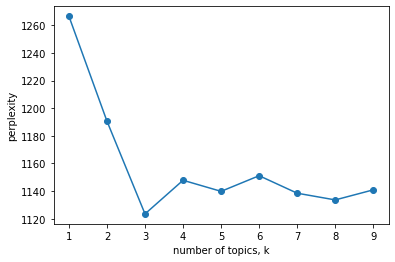

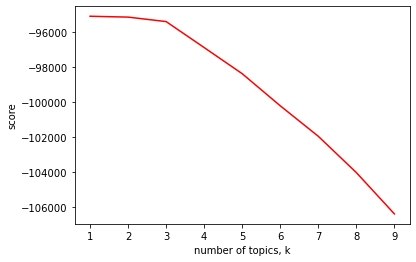

In [8]:
#Estimando LDA con Bayes variacional
# Ciclo para determinar número de tópicos utilizando perplexity y loglikelihood (score)
from sklearn.decomposition import LatentDirichletAllocation
num_k = range(1, 10)
perp = []
score = []

for k in num_k:
    
    #Estimación de LDA con Bayes Variacional
    lda = LatentDirichletAllocation(n_components=k, max_iter=10,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

    lda.fit(tf)
    #Cálculo de índice de ajuste de los datos
    perp.append(lda.perplexity(tf,sub_sampling=True))
    score.append(lda.score(tf))
   
    
    
plt.plot(num_k, perp, '-o')
plt.xlabel('number of topics, k')
plt.ylabel('perplexity')
plt.xticks(num_k)
plt.show()

plt.plot(num_k,score,color="red")
plt.xlabel('number of topics, k')
plt.ylabel('score')
plt.xticks(num_k)
plt.show()



#print("\nTopics in LDA model:")
#print_top_words(lda, diccionario, 15)

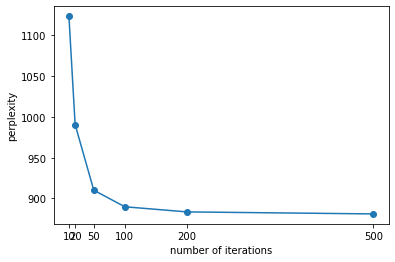

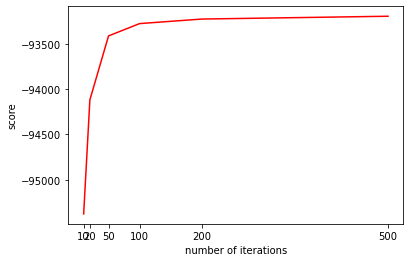

In [9]:
#Verificando que el número de iteraciones es correcto para el número de tópicos seleccionado
n_iter = [10,20,50,100,200,500]

perp = []
score = []
true_k=3
for i in n_iter:
    #Estimación de LDA con Bayes Variacional
    lda = LatentDirichletAllocation(n_components=true_k, max_iter=i,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

    lda.fit(tf)
    #Cálculo de índice de ajuste de los datos
    
    perp.append(lda.perplexity(tf,sub_sampling=True))
    score.append(lda.score(tf))
    
plt.plot(n_iter, perp, '-o')
plt.xlabel('number of iterations')
plt.ylabel('perplexity')
plt.xticks(n_iter)
plt.show()

plt.plot(n_iter,score,color="red")
plt.xlabel('number of iterations')
plt.ylabel('score')
plt.xticks(n_iter)
plt.show()

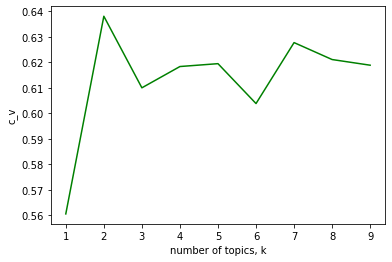

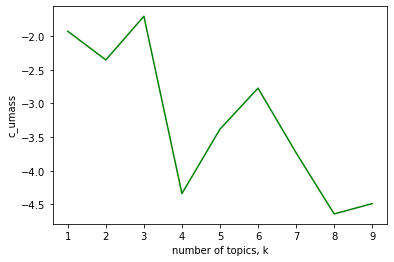

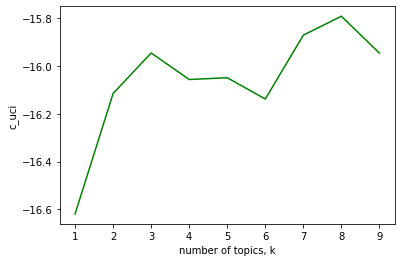

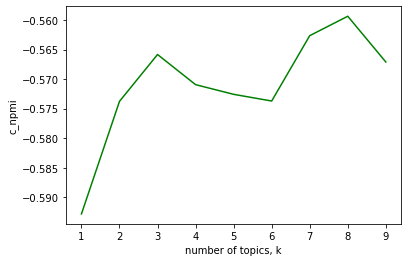

In [10]:
#Evaluando el número de tópicos con distintas medidas de coherencia
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

X_inv =  tf_vectorizer.inverse_transform(tf)
vocab = np.array([x for x in tf_vectorizer.vocabulary_.keys()])

num_k = range(1, 10)


c_v = []
c_umass = []
c_uci = []
c_npmi = []
for k in num_k:
    
    #Estimación de LDA con Bayes Variacional
    lda = LatentDirichletAllocation(n_components=k, max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

    lda.fit(tf)
    #Cálculo de medidas de coherencia de la estructura de tópicos
    
    c1 = metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=lda.components_, 
                        dtm=tf, 
                        vocab=vocab,
                        texts=X_inv)
    c_v.append(np.mean(c1))
    
    c2 = metric_coherence_gensim(measure='u_mass', 
                        top_n=25, 
                        topic_word_distrib=lda.components_, 
                        dtm=tf, 
                        vocab=vocab,
                        texts=X_inv)
    c_umass.append(np.mean(c2))
    
    c3 = metric_coherence_gensim(measure='c_uci', 
                        top_n=25, 
                        topic_word_distrib=lda.components_, 
                        dtm=tf, 
                        vocab=vocab,
                        texts=X_inv)
    c_uci.append(np.mean(c3))
    
    c4 = metric_coherence_gensim(measure='c_npmi', 
                        top_n=25, 
                        topic_word_distrib=lda.components_, 
                        dtm=tf, 
                        vocab=vocab,
                        texts=X_inv)
    c_npmi.append(np.mean(c4))
    
    


plt.plot(num_k,c_v,color="green")
plt.xlabel('number of topics, k')
plt.ylabel('c_v')
plt.xticks(num_k)
plt.show()

plt.plot(num_k,c_umass,color="green")
plt.xlabel('number of topics, k')
plt.ylabel('c_umass')
plt.xticks(num_k)
plt.show()

plt.plot(num_k,c_uci,color="green")
plt.xlabel('number of topics, k')
plt.ylabel('c_uci')
plt.xticks(num_k)
plt.show()

plt.plot(num_k,c_npmi,color="green")
plt.xlabel('number of topics, k')
plt.ylabel('c_npmi')
plt.xticks(num_k)
plt.show()


In [11]:
#cálculo de medidas de coherencia por tópico
res = []
lda = LatentDirichletAllocation(n_components=true_k, max_iter=100,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

lda.fit(tf)
res.append(metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=lda.components_, 
                        dtm=tf, 
                        vocab=np.array([x for x in tf_vectorizer.vocabulary_.keys()]),
                        texts=tf_vectorizer.inverse_transform(tf)))
print(res[0])

res.append(metric_coherence_gensim(measure='c_uci', 
                        top_n=25, 
                        topic_word_distrib=lda.components_, 
                        dtm=tf, 
                        vocab=np.array([x for x in tf_vectorizer.vocabulary_.keys()]),
                        texts=tf_vectorizer.inverse_transform(tf)))
print(res[1])

res.append(metric_coherence_gensim(measure='c_npmi', 
                        top_n=25, 
                        topic_word_distrib=lda.components_, 
                        dtm=tf, 
                        vocab=np.array([x for x in tf_vectorizer.vocabulary_.keys()]),
                        texts=tf_vectorizer.inverse_transform(tf)))
print(res[2])

res.append(metric_coherence_gensim(measure='u_mass', 
                        top_n=25, 
                        topic_word_distrib=lda.components_, 
                        dtm=tf, 
                        vocab=np.array([x for x in tf_vectorizer.vocabulary_.keys()]),
                        texts=tf_vectorizer.inverse_transform(tf)))

print(res[3])



[0.5901622341690546, 0.6120270594813305, 0.5490153494807359]
[-15.773416833391543, -15.883549429977124, -16.032258737521932]
[-0.554271704254799, -0.5652316875830017, -0.5646863783359488]
[-2.0252768606732454, -1.8008749343298824, -0.6600528786039652]


[[9.95274793e-01 2.38992816e-03 2.33527866e-03]
 [5.37865825e-03 2.40838148e-01 7.53783193e-01]
 [9.91468872e-01 4.53630418e-03 3.99482355e-03]
 [1.85261403e-03 9.96469255e-01 1.67813105e-03]
 [8.92476663e-04 9.98317718e-01 7.89804941e-04]
 [9.10383626e-01 8.82692122e-02 1.34716201e-03]
 [4.26051408e-03 4.30867052e-03 9.91430815e-01]
 [5.60115225e-04 5.55134117e-04 9.98884751e-01]
 [3.79739392e-03 9.92421616e-01 3.78099048e-03]
 [3.79008236e-03 9.92789910e-01 3.42000797e-03]
 [4.24916628e-03 4.21760486e-03 9.91533229e-01]
 [4.69303494e-03 9.90935676e-01 4.37128944e-03]
 [1.29626629e-03 1.32161138e-03 9.97382122e-01]
 [9.94624252e-01 2.71694256e-03 2.65880576e-03]
 [9.85113809e-01 7.74633282e-03 7.13985847e-03]
 [3.09795567e-03 9.93980594e-01 2.92145066e-03]
 [9.93271507e-01 3.28664309e-03 3.44184969e-03]
 [9.94150689e-01 3.01140847e-03 2.83790236e-03]
 [1.38878349e-03 9.97194708e-01 1.41650804e-03]
 [5.30084223e-03 9.89431592e-01 5.26756576e-03]
 [4.59166627e-03 9.90777160e-01 4.631173

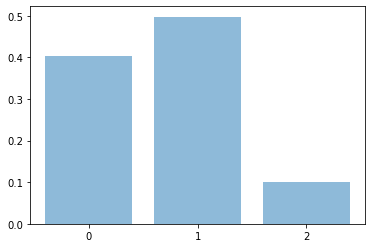

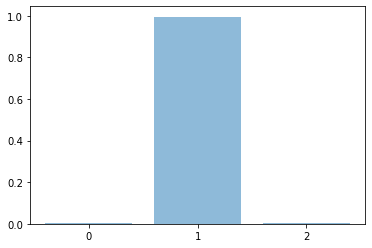

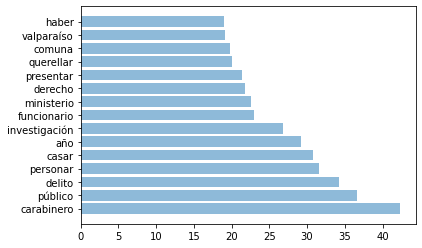

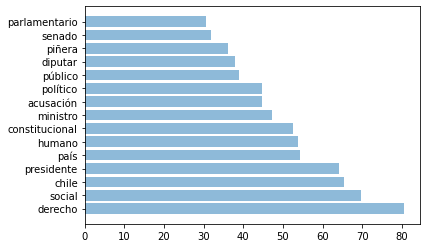

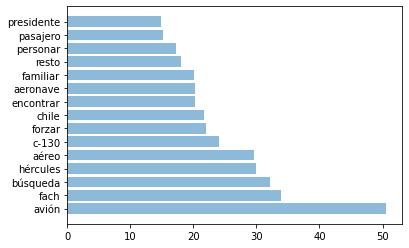

In [76]:
#Generando algunos gráficos de los resultados
from matplotlib.pylab import hist, show
import seaborn as sns


y=lda.fit_transform(tf)

print(y)
#distribución de tópicos en todos los documentos
dist = sum(y)/len(noticias)
print(dist)

w=np.arange(0,true_k)
print(w)
plt.bar(w,height=dist,alpha=0.5,tick_label=w)
show()
#distribución de tópicos en el documento 100
plt.bar(w,height=y[98],alpha=0.5,tick_label=w)
show()


#frecuencia de palabras por tópico
n_top_words=15
numo =np.arange(0,n_top_words)
for idx,topic in enumerate(lda.components_):
    d = []
    s = []
    for i in topic.argsort()[:-n_top_words - 1:-1]:
          s.append(diccionario[i])
          d.append(topic[i])
    
    plt.barh(numo,width=d,alpha=0.5,tick_label=s)
    show()


<div style="border: 2px solid #1c75c8; background-color: #F8B4B4">
<p>Una nueva estimación para algoritmo LDA considerando <a href="https://drive.google.com/open?id=1oSRRvG_W0UaH0l4o9f5ClEyWuGY1j-s0"> Gibbs Sampling</a>, disponible como desarrollo en <a href="https://github.com/lda-project/lda/">lda-project.</a></p> 
</div>

In [24]:
#Estimación de LDA con Gibbs sampling
#Ciclo para determinar número de tópicos utilizando perplexity y loglikelihood (score)
from math import *
from random import sample
import numpy as np
import matplotlib.pyplot as plt
import lda


def perplexity(model,test, nDoc,nVocab,nTopic):
    topic_word = model.components_
    pt = model.nz_/np.sum(model.nz_)
    pw = []
    num_v = range(0,nVocab-1)
    num_k = range(0,nTopic-1)
    for n in num_v:
        sum=0
        for k in num_k:
            sum+=topic_word[k][n]*pt[k]  
        pw.append(sum)

    perp =0
    sum1 =0
    sum2 =0
    dtf =test.todense()
    num_d = range(0,test.shape[0]-1)
    for n in num_d:
        for j in num_v:
            prob = pow(pw[j], dtf[n,j])
            if prob >0:
                sum1 += log(prob)
            sum2 += np.sum(dtf[n,j]) 
    perp = exp(-(sum1/sum2))  
    return(perp)
   

true_k=3
tf = tf[:][:].astype(int)

nDoc = tf.shape[0]
nVocab = tf.shape[1]
size = int(nDoc*0.8)
ind = range(0,nDoc-1)
ind1 = sample(ind,size)
ind2 = np.setdiff1d(ind, ind1)
train = tf[ind1]
test = tf[ind2]




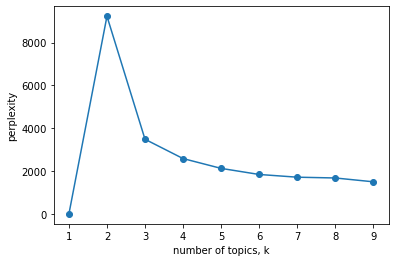

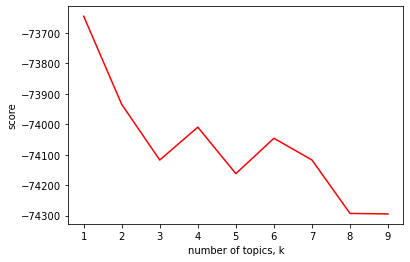

In [25]:
import logging
logging.getLogger().setLevel(100)

num_k = range(1, 10)
perp = []
score = []

for k in num_k:
    
    #Estimación de LDA con Gibbs Sampling
    model = lda.LDA(n_topics=k, n_iter=2000, alpha=0.1, eta=0.1, random_state=3)
    aux = model.fit(train)  # model.fit_transform(X) is also available

    topic_word = model.topic_word_  # model.components_ also works
    #Cálculo de índice de ajuste de los datos
    
    perp.append(perplexity(model,test, nDoc, nVocab, k))
    score.append(max(model.loglikelihoods_[5:]))
   
    
    
plt.plot(num_k, perp, '-o')
plt.xlabel('number of topics, k')
plt.ylabel('perplexity')
plt.xticks(num_k)
plt.show()

plt.plot(num_k,score,color="red")
plt.xlabel('number of topics, k')
plt.ylabel('score')
plt.xticks(num_k)
plt.show()



**Ejercicio:**

1) Verificar que el número de iteraciones es correcto para el número de tópicos seleccionado

2) Evalue el número de tópicos con distintas medidas de coherencia

3) Para el número de tópicos seleccionado, calcule las distintas medidas de coherencia por tópico. Interprete y concluya.


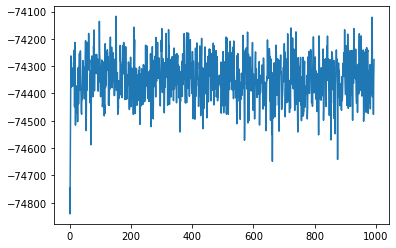

In [31]:
plt.plot(model.loglikelihoods_[5:])

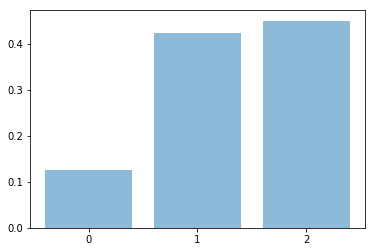

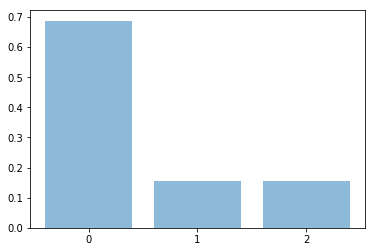

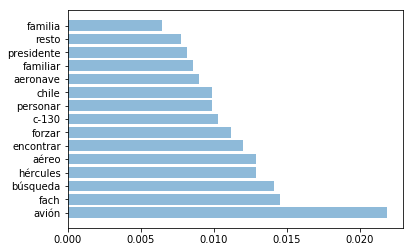

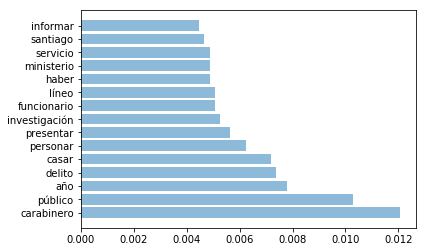

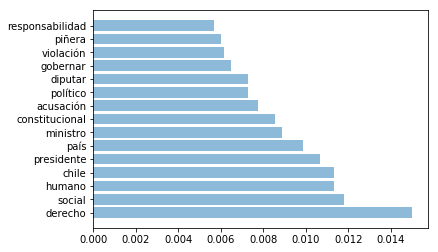

In [32]:
#Generando algunos gráficos de los resultados
from matplotlib.pylab import hist, show

y=model.doc_topic_
#distribución de tópicos en todos los documentos
dist = sum(y)/len(noticias)
w=np.arange(0,true_k)
plt.bar(w,height=dist,alpha=0.5,tick_label=w)
show()

#distribución de tópicos en el documento 100
plt.bar(w,height=y[99],alpha=0.5,tick_label=w)
show()

#frecuencia de palabras por tópico
n_top_words=15
numo =np.arange(0,n_top_words)

for idx,topic in enumerate(model.topic_word_):
    d =[]
    s = []
    for i in topic.argsort()[:-n_top_words - 1:-1]:
          s.append(diccionario[i])
          d.append(topic[i])
    
    plt.barh(numo,width=d,alpha=0.5,tick_label=s)
    show()



